In [2]:
!curl -x socks5://localhost:1080 https://www.themoviedb.org/


<!DOCTYPE html>
<html lang="fi" class="no-js">
  <head>
    <title>The Movie Database (TMDB)</title>
    <meta http-equiv="cleartype" content="on">
    <meta charset="utf-8">
    <meta name="keywords" content="Movies, TV Shows, Streaming, Reviews, API, Actors, Actresses, Photos, User Ratings, Synopsis, Trailers, Teasers, Credits, Cast">
    <meta name="mobile-web-app-capable" content="yes">
    <meta name="apple-mobile-web-app-capable" content="yes">
    <meta name="viewport" content="width=device-width,initial-scale=1">
      <meta name="description" content="The Movie Database (TMDB) is a popular, user editable database for movies and TV shows.">
    <meta name="msapplication-TileImage" content="/assets/2/v4/icons/mstile-144x144-30e7905a8315a080978ad6aeb71c69222b72c2f75d26dab1224173a96fecc962.png">
<meta name="msapplication-TileColor" content="#032541">
<meta name="theme-color" content="#032541">
<link rel="apple-touch-icon" sizes="180x180" href="/assets/2/apple-touch-icon-57ed4b3b04

In [32]:
import re
import os
import nltk
import numpy as np
import json
from threading import Timer
from collections import Counter
import torch
import faiss                 
from transformers import AutoModel, AutoTokenizer
import ollama
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def clean(note):
    # remove zero-links
    note = re.sub(r'\[.*\]', '', note)
    # remove tags and headers
    note = re.sub(r'\#.*\n', '', note)
    # remove lines
    note = re.sub('---', ' ', note)
    # remove **
    note = re.sub('\*', '', note)
    
    return note

def clean_thought(thought):
    thought = re.sub(r'\(http\S+', '<LINK>', thought)
    thought = re.sub(r'http\S+', '<LINK>', thought)

    if thought[:2] == '- ':
        thought = thought[2:]

    if '<LINK>' in thought:
        linkless = re.sub('<LINK>', '', thought)
        linkless = re.sub('[^a-zA-Zа-яА-Я ]', '',  linkless)
        linkless = linkless.strip()
        if len(linkless.split(' ')) < 2:
            return ''
    
    return thought.strip()


def filter_thought(thought):
    if not thought:
        return False
    
    thought = str(thought)
    letters_only = re.sub('[^a-zA-Zа-яА-Я]', '',  thought)
    if len(letters_only) < 30:
        return False
    
    words_only = re.sub('[^a-zA-Zа-яА-Я ]', '',  thought)
    if len(words_only.split(' ')) < 10:
        return False
    
    return True


def find_tags(note):
    tags = re.findall("\B(\#[a-zA-Z]+(\n|\ ))", note)
    tags = [t.split(s)[0][1:] for (t, s) in tags]
    return tuple(tags)


def parse_folder(db_path, len_thr=40):
    path, folders, files = next(os.walk(db_path))

    subfolder_dbs = []
    if len(folders) > 0:
        for f in folders:
            folder_path = os.path.join(path, f)
            folder_db = parse_folder(folder_path, len_thr)
            subfolder_dbs += folder_db

    db = []
    for fn in files:
        if '.md' not in fn:
            continue

        filepath = os.path.join(path, fn)
        with open(filepath, 'r') as f:
            note = f.read()

        if len(note) < len_thr:
            continue
        cleaned_note = clean(note)
        tags = find_tags(note)
        # sentences = get_sentences(cleaned_note)
        # paragraphs = get_paragraphs(cleaned_note)
        # llm_thoughts = llm_get_thoughts(cleaned_note)
        note_dict = {'name': fn.split('.md')[0], 'path':filepath, 
                     'note':note, 'cleaned_note': cleaned_note, 
                    #  'llm_thoughts': llm_thoughts, 
                    #  'sentences': sentences, 
                    # "paragraphs": paragraphs, 
                     'tags': tags}
        db.append(note_dict)

    db = db + subfolder_dbs
    return db


def get_sentences(note):
    sentences = [t for thought in re.split('\n|\t', note) for t in nltk.sent_tokenize(thought)]
    cleaned = list(map(clean_thought, sentences))
    filtered = list(filter(filter_thought, cleaned))
    return filtered

def get_paragraphs(note):
    paragraphs = [p for p in re.split('\n\n', note)]
    cleaned = list(map(clean_thought, paragraphs))
    filtered = list(filter(filter_thought, cleaned))
    return filtered


def llm(query):
    response = ollama.chat(model='llama3',
                            messages=[{'role': 'user', 
                                        'content': query}])
    return response['message']['content']

def llm_get_thoughts(text):
    try:
        prompt = '''Summarize the following text in 2-3 sentences, formulate it very concisely. Text: {} Output only the concise summary, 2-3 sentences.'''
        query = prompt.format(text[:20_000])
        ans = llm(query)
        if '\n' in ans: 
            ans = ans.split('\n')[-1]
        thoughts = ans.split('.')
        thoughts = list(filter(len, thoughts))
        thoughts = [t.strip() for t in thoughts]
        return thoughts
    except Exception as e:
        print(f"Got error with ollama: {e}")
        return

def add_fields(note, text):
    if not note.get('llm_thoughts'):
        note['llm_thoughts'] = llm_get_thoughts(text)
    if not note.get('sentences'):
        note['sentences'] = get_sentences(text)
    if not note.get('paragraphs'):
        note['paragraphs'] = get_paragraphs(text)


# SEARCH_FIELDS = ['cleaned_note', 'sentences', 'paragraphs', 'llm_thoughts']
SEARCH_FIELDS = ['sentences', 'paragraphs', 'llm_thoughts']
class NoteManager:
    def __init__(self, db_path, 
                        model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
                        device='cpu',
                        save_path='../saved',
                        batch_size=32,
                        from_scratch=False):
        os.makedirs(save_path, exist_ok=True)
        
        self.db_path, self.save_path, self.batch_size = db_path, save_path, batch_size
        self.init_model(model_name, device)
        self.load_db(from_scratch)
        self.parse_notes()
        # self.start_timer()
    
    def get_nearest(self, text, k=5, by_field='sentence'):
        index = self.index[by_field]

        text_emb = self.embed([clean(text)])
        D, I = index.search(torch.stack(text_emb), k)

        nearest = self.get_notes_by_field(by_field, I[0])
        for i, n in enumerate(nearest):
            n['distance'] = D[0][i]
        nearest = sorted(nearest, key=lambda n: n['distance'])
        return nearest

    def get_nearest_all_fields(self, text, k=5):
        note = {}
        add_fields(note, text)
        nearest = []
        for field in note:
            note_f = note[field]
            if not note_f:
                continue
            if type(note_f) == str:
                note_f = [note_f]
            for text in note_f:
                nearest_f = self.get_nearest(text, k, field) 
                for n in nearest_f:
                    n['search_field'] = field
                nearest += nearest_f
        return sorted(nearest, key=lambda n: n['distance'])
    
    def suggest_tags(self, text):
        drop_tags = {''}
        nearest = self.get_nearest_all_fields(text, 10)
        
        all_tags = [t for n in nearest for t in n['tags']]
        all_tags = list(filter(lambda x: x not in drop_tags, all_tags))
        suggested_tags = [t[0] for t in Counter(all_tags).most_common(4)]
        return suggested_tags
    
    def parse_notes(self):
        print("### Parsing notes ###")
        loaded = parse_folder(self.db_path, len_thr=40)

        self.add_notes(loaded)
        self.extract_thoughts()
        self.build_index()
        self.embed_database()
        self.save()

    def add_notes(self, notes):
        print("### Adding notes ###")
        # Create dictionaries for fast lookups by 'path'
        db_dict = {n['path']: n for n in self.db}
        loaded_db_dict = {n['path']: n for n in notes}

        new_notes = {path: n for path, n in loaded_db_dict.items() if path not in db_dict}
        changed_notes = {path: n for path, n in loaded_db_dict.items() if path in db_dict and db_dict[path]['note'] != n['note']}
        deleted_note_paths = {path for path in db_dict if path not in loaded_db_dict}

        for path in changed_notes:
            del db_dict[path]

        for path in deleted_note_paths:
            del db_dict[path]

        # Update database with new notes
        self.db = list(db_dict.values()) + list(new_notes.values()) + list(changed_notes.values())
    
    def extract_thoughts(self):
        print("### Extracting thoughts ###")
        for n in self.db:
            cn = n['cleaned_note']
            add_fields(n, cn)
    
    def build_index(self):
        print("### Buliding index ###")
        self.f2i = dict()
        for field in SEARCH_FIELDS:
            note_inds = []
            field_inds = []
            for note_ind, note in enumerate(self.db):
                nf = note[field]
                if type(nf) == str:
                    note_inds.append(note_ind)
                    field_inds.append(0)
                elif type(nf) == list:
                    note_inds += [note_ind] * len(nf)
                    field_inds += list(range(len(nf)))
            element_inds = range(len(note_inds))
            self.f2i[field] = dict(zip(element_inds, zip(note_inds, field_inds)))
    
    def embed_database(self):
        print("### Embedding DB ###")
        self.index = dict()
        for field in SEARCH_FIELDS:
            embeddings = []
            emb_field = f"{field}_emb"
            for note in self.db:
                if emb_field in note:
                    emb = note[emb_field]
                else:
                    nf = note[field]
                    if type(nf) == str:
                        emb = self.embed([nf])
                    elif type(nf) == list:
                        emb = self.embed(nf)

                    note[emb_field] = emb
                embeddings += emb 
            if not embeddings:
                continue
            
            index = faiss.IndexFlatL2(self.model.config.hidden_size)
            index.add(torch.vstack(embeddings))
            self.index[field] = index
    
    def get_notes_by_field(self, by_field, inds):
        f2i = self.f2i[by_field]
        out = []
        for i in inds:
            o = dict(**self.db[f2i[i][0]])
            o['nearest_field'] = f2i[i][1]
            out.append(o)
        return out

    def create_index(self, emb_matrix):
        self.index = faiss.IndexFlatL2(self.model.config.hidden_size)
        self.index.add(emb_matrix)
  
    def embed(self, texts, batch_size=32):
        embeddings = []
        for i in range(0, len(texts), batch_size):
            text_batch = texts[i:i+batch_size]
            tokenized = self.tokenizer.batch_encode_plus(text_batch, return_tensors='pt', padding='max_length', truncation=True)
            for t in tokenized:
                tokenized[t] = tokenized[t].to(self.device)
            with torch.no_grad():
                encoded = self.model(**tokenized)
            for bn, states in enumerate(encoded.last_hidden_state):
                emb = states[tokenized['attention_mask'][bn] == 1].mean(dim=0).cpu().detach()
                embeddings.append(emb)

        return embeddings

    def init_model(self, model_name, device):
        print("### Loading model ###")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.model.eval()
        self.model.to(device)
        self.device = device

    def load_db(self, from_scratch=False):
        db_path = os.path.join(self.save_path, 'note_db.npy')
        if not os.path.exists(db_path) or from_scratch:
            self.db = []
        else:
            self.db = np.load(db_path, allow_pickle=True)
    
    def save(self):
        os.makedirs(self.save_path, exist_ok=True)
        db_path = os.path.join(self.save_path, 'note_db.npy')
        np.save(db_path, self.db)
    
    def start_timer(self):
        class RepeatTimer(Timer):
            def run(self):
                while not self.finished.wait(self.interval):
                    self.function(*self.args, **self.kwargs)

        self.timer = RepeatTimer(1800, self.parse_notes)
        self.timer.start()

In [33]:
# loaded = parse_folder("/home/booydar/sync/obsidian-db", len_thr=40)

In [34]:
tm = NoteManager(db_path="/home/booydar/Sync/obsidian-db-test",
                    device='cuda',
                    save_path="./saved_thoughts",
                    batch_size=64,
                    # from_scratch=True
                    )

### Loading model ###
### Parsing notes ###
### Adding notes ###
### Extracting thoughts ###
### Buliding index ###
### Embedding DB ###


In [35]:
tm.db[0]['tags']

('rmt', 'nlp', 'science')

In [36]:
# text = "where memory can be passed not only from last layer to next segment first layer"
text = '''Time is clearly important in cognition. It is inextricably bound up with many behaviors (such as language) which express themselves as temporal sequences. Indeed, it is difficult to know how one might deal with such basic problems as goal-directed behavior, planning, or causation without some way of representing time.'''
field = 'sentences'
tm.suggest_tags(text)

Got error with ollama: [Errno 104] Connection reset by peer


['voice', 'nlp', 'life', 'random']

In [37]:
# text = "where memory can be passed not only from last layer to next segment first layer"
text = '''Time is clearly important in cognition. It is inextricably bound up with many behaviors (such as language) which express themselves as temporal sequences. Indeed, it is difficult to know how one might deal with such basic problems as goal-directed behavior, planning, or causation without some way of representing time.'''
field = 'sentences'
nearest = tm.get_nearest_all_fields(text, k=3)
for n in nearest:
    print('-'*25)
    print(n['distance'], n['search_field'], n[n['search_field']][n['nearest_field']])

Got error with ollama: [Errno 104] Connection reset by peer
-------------------------
10.67206 paragraphs Complicated timeseries are unpredictable, however by learning to predict the following value we understand patterns that are embedded in timeseries. With the embedding achieved by pre-training we can train a new model on a downstream task, i.e. predicting fluctuations, buy/sell signals etc.
-------------------------
10.847677 sentences Таким образом, механизм внимания сильно связан с во-рту век, точнее с непрерывным мешком слов.
-------------------------
10.923315 paragraphs 17.01.23
- натравить нейронку на ее же сгенеренный бред с целью объяснить или получить верное решение
- какие-то правила языка/задачи/реального мира, чтобы отсекать из памяти  несвязанные с задачей категории
- либо когда понятно, что что-то точно не нужно, то про это вообще забыть. например, когда закончили один этап задачи, то все указывающие на него наводки
-------------------------
11.010994 sentences часто 

In [38]:
self = tm
k = 5
text = '''Нейросеть как защищённый архиватор и для информации, используемые идеи юры о том, что можно подобрать специальные токены памяти на входе. Таким образом, чтобы при использовании этих токенов, что-то наперёд заданное. Это можно сделать довольно большой точностью, сжав от 100 до 500 символов в один токен за 5.000. Идея при условии того, что они используют одну и ту же архитектуру нейронной сети с одними и теми же весами. Интерес состоит в том, что без использования без использования той же самой нейросети не получится разархивировать сжатую в токенах информацию. Таким образом, мы получаем алгоритм, какие же веса нужно обучать нейросеть на протяжении большого количества времени, особенно если нейросеть с большим количеством параметров проблемы. Конечно, же возникают из-за того, что коэффициент сжатия таким образом не слишком высок и сам процесс архивирования и разархивирование происходит долго. С другой стороны. Нет необходимости требовать от такого архиватора точности разжатия информации вплоть до символа можно потребовать лишь. Близко к тому, чтобы было заархивировать это семантическая близость может требоваться в задачах типа ответы на вопросы, либо какого-то семантического поиска, что ты ещё точно можно на эту тему придумать. Таким образом, кажется, что тёма архивирования и разархивирование с нейросетями может быть улучшено за счёт того, что у самой языковой модели, которую мы можем для этого использовать уже есть какие-то значительные способности познанию мира и ширина знаний. '''

In [44]:
note = {}
add_fields(note, text)
nearest = []
for field in note:
    note_f = note[field]
    if type(note_f) == str:
        note_f = [note_f]
    for text in note_f:
        print(field, text)
        nearest_f = self.get_nearest(text, k, field) 
        for n in nearest_f:
            n['search_field'] = field
        nearest += nearest_f
# return sorted(nearest, key=lambda n: n['distance'])

llm_thoughts A neural network can be used as an archiver and compressor, allowing it to encode information into special memory tokens that can later be decoded with high accuracy
llm_thoughts The process relies on training the same neural network architecture with the same weights, making it difficult to compress or decompress information without using this specific network
llm_thoughts This approach enables semantic compression and retrieval of information, which may be useful in tasks such as answering questions or searching for related concepts
sentences Нейросеть как защищённый архиватор и для информации, используемые идеи юры о том, что можно подобрать специальные токены памяти на входе.
sentences Таким образом, чтобы при использовании этих токенов, что-то наперёд заданное.
sentences Это можно сделать довольно большой точностью, сжав от 100 до 500 символов в один токен за 5.000.
sentences Идея при условии того, что они используют одну и ту же архитектуру нейронной сети с одними и 

In [67]:
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt
def get_mean_dists(self):
    md = {}
    for field in SEARCH_FIELDS:
        index = tm.index[field]
        emb = index.reconstruct_batch(range(index.ntotal))
        pd = pairwise_distances(emb, emb)
        # md[field] = pd[pd > 0].mean()
        md[field] = np.median(pd[pd > 0])
    self.md = md

get_mean_dists(self)

In [68]:
nearest = sorted(nearest, key=lambda n: n['distance'] / self.md[n['search_field']])

In [69]:
# note

In [70]:
for n in nearest:
    print('-'*25)
    print(n['distance'], n['distance'] / self.md[n['search_field']], n['search_field'], n[n['search_field']][n['nearest_field']])

-------------------------
3.6831841 0.79827654 paragraphs Фрактальная мера и размерность Хаусдорфа. Сегодня на лекции по математике проходили фрактальные меры, которые основываются на покрытие множества другими множествами, а в частности, мера Хаусдорфа — Ibox мира их отличия в основном в том, что в бокс в мире мы используем покрытие множества всякими и объектами фиксированным диаметром, а эльфы мере у нас больше пространства диаметр должен быть не больше. Какого-то значения, чем это хорошо. Так, тем, что мы можем использовать этот для расчёта меры на объектах, которыми обычное расстояние бессильны или выдаёт какое-то значение, которое мы не хотим получать. В частности, множество кантора имеет вполне адекватную хаусдорфову меру логарифм 2 / логарифм 3, когда обычно его длина равна 0-,5 на металлических. А метрика это в принципе центральное понятие для машинного обучения, потому что на основании метрики строятся расстояние так вот где может быть полезна эта теория в машинном обучении, н

In [ ]:
for n in nearest:
    print('-'*25)
    print(n['distance'], n['search_field'], n[n['search_field']][n['nearest_field']])

-------------------------
3.6831841 paragraphs Фрактальная мера и размерность Хаусдорфа. Сегодня на лекции по математике проходили фрактальные меры, которые основываются на покрытие множества другими множествами, а в частности, мера Хаусдорфа — Ibox мира их отличия в основном в том, что в бокс в мире мы используем покрытие множества всякими и объектами фиксированным диаметром, а эльфы мере у нас больше пространства диаметр должен быть не больше. Какого-то значения, чем это хорошо. Так, тем, что мы можем использовать этот для расчёта меры на объектах, которыми обычное расстояние бессильны или выдаёт какое-то значение, которое мы не хотим получать. В частности, множество кантора имеет вполне адекватную хаусдорфову меру логарифм 2 / логарифм 3, когда обычно его длина равна 0-,5 на металлических. А метрика это в принципе центральное понятие для машинного обучения, потому что на основании метрики строятся расстояние так вот где может быть полезна эта теория в машинном обучении, например, ко

### Analyze distance statistics 

In [48]:
from sklearn.metrics import pairwise_distances
from matplotlib import pyplot as plt

In [58]:
def get_mean_dists(self):
    md = {}
    for field in SEARCH_FIELDS:
        index = tm.index[field]
        emb = index.reconstruct_batch(range(index.ntotal))
        pd = pairwise_distances(emb, emb)
        md[field] = pd[pd > 0].mean()
    self.md = md

In [60]:
get_mean_dists(self)

In [61]:
self.md

{'sentences': 5.226288, 'paragraphs': 4.595596, 'llm_thoughts': 5.670119}

In [53]:
by_field = 'sentences'
index = tm.index[by_field]
emb = index.reconstruct_batch(range(index.ntotal))
pd = pairwise_distances(emb, emb)
pd[pd > 0].mean()

5.226288

In [54]:
by_field = 'paragraphs'
index = tm.index[by_field]
emb = index.reconstruct_batch(range(index.ntotal))
pd = pairwise_distances(emb, emb)
pd[pd > 0].mean()

4.595596

In [55]:
by_field = 'llm_thoughts'
index = tm.index[by_field]
emb = index.reconstruct_batch(range(index.ntotal))
pd = pairwise_distances(emb, emb)
pd[pd > 0].mean()

5.670119

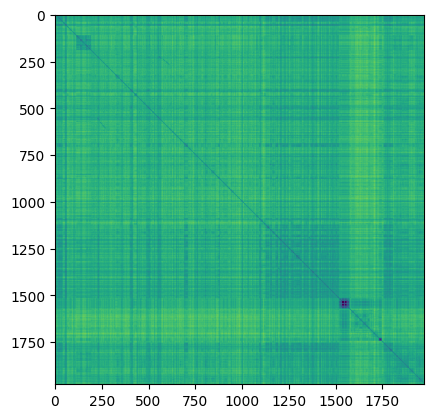

In [49]:
by_field = 'sentences'
index = tm.index[by_field]
emb = index.reconstruct_batch(range(index.ntotal))
pd = pairwise_distances(emb, emb)
plt.imshow(pd)

(array([  9.,  82., 241., 445., 556., 399., 195.,  42.,   5.,   1.]),
 array([4.01571131, 4.29242134, 4.5691309 , 4.84584093, 5.12255096,
        5.39926052, 5.67597055, 5.95268059, 6.22939062, 6.50610018,
        6.78281021]),
 <BarContainer object of 10 artists>)

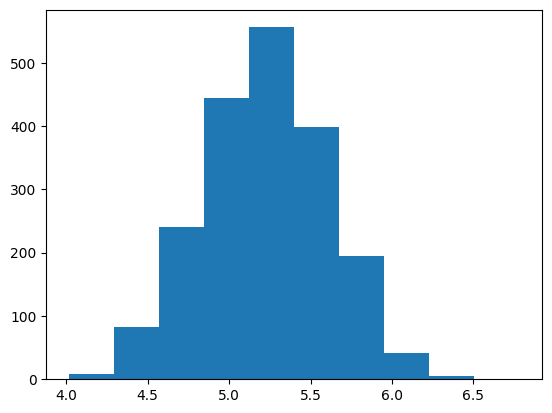

In [39]:
mean_dists = pd.mean(axis=1)
plt.hist(mean_dists)

In [49]:
nearest_to_all = np.argsort(mean_dists)
nearest_to_all_notes = tm.get_notes_by_field(by_field, nearest_to_all)
nearest_to_all_sentences = [n[by_field][n['nearest_field']] for n in nearest_to_all_notes]


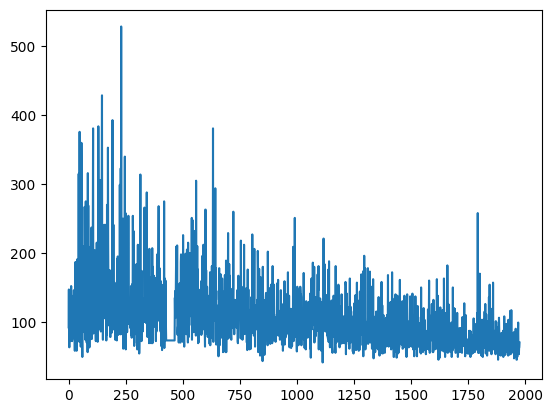

In [51]:
nl = list(map(len, nearest_to_all_sentences))
plt.plot(nl)

In [52]:
nearest_to_all_sentences[:10]

['Причем оценки можно собирать не только из самой системы, но и из внешних предпочтений юзера.',
 'также очевидно нужно смотреть на него с разных перспектив - написано максимально разных областей знания, которые привели к изучению этого предмета.',
 'например, когда закончили один этап задачи, то все указывающие на него наводки',
 'еще похоже на  конечно же, но надо думать, как именно притянуть',
 'для этого проходиться по статьям и выделять банальные базовые вещи и записывать их систематически.',
 'Запись в память для континуал лернинга должна производиться по результатам ответа и предикта,',
 'системы напомнишь rlhf, но должна обучаться целям суммой модели, а не сомневаться из человеческих предпочтений.',
 'короче надо все это отбрасывать и делать большие контексты с итеративным улучшением ответа',
 'признаки индивидуальны для каждой задачи, но можно сделать их латентными',
 'В этом туториале вы узнаете, как добавить экспрессивность в свои тексты, используя различные техники и приёмы

In [53]:
nearest_to_all_sentences[-10:]

['dreamer v3 is the only model that can find diamonds in Minecraft',
 'Touch and hold for half a second, then move to wipe away previous drawings',
 'As a result, a fused kernel completes all the following operations at the same time:',
 'Each drawing on the chalkboard is added after the slide that was shown when opening the chalkboard.',
 'They are now actively stealing human knowledge from all history.',
 'you can open a chalkboard or whiteboard on which you can make notes.',
 'Touch and move to write on notes canvas or chalkboard',
 'Drawings on the notes canvas are not included in the PDF-file.',
 'It looks like you might have accidentally sent a blank message.',
 'The trophy would not fit in the brown suitcase because it was too big.']

### Does accounting for nearest distance help?

In [85]:
# text = "Нейросетевая память как аугментация для мозга, обучаемая и автоматизированная."
text = "Смысл науки в целом состоит в некоем поиске"

by_field = 'sentences'
nearest = tm.get_nearest(text, 20, 'sentences')

nearest_sentences = [n[by_field][n['nearest_field']] for n in nearest]

nearest_sentences

['Нужно почувствовать в себе то, чем я хочу заниматься почувствовать ту область науки, которая вызывает наибольшую отдачу и потом выбрать задачи в области, которая задействует эту область науки и всячески выстраивает своё понимание своё научную интуицию, чтобы оставаться в этой области в этом потоке.',
 'лучше искать проблемы, которые неявно прослеживаются в работе многих ученых, чем придумывать интересные лично тебе',
 'за гранью науки лежат затычки, дальше которых не может проникать достоверное знание и данные.',
 'понимание смысла у каждого извращенно и имеет больше отношения к биохимии, чем к истине)',
 'также очевидно нужно смотреть на него с разных перспектив - написано максимально разных областей знания, которые привели к изучению этого предмета.',
 'понятия книги, философия Гегеля и веды тесно связаны, они были вполне едины пока не были замещены экспериментальной наукой',
 'Мейясу (После конечности) : отсутствие достаточного основания и есть конечное воспринимаемое свойство люб

In [89]:
corrected_ids

array([ 0,  1,  2,  3,  9,  5, 18,  8,  4,  7, 12,  6, 15, 24, 17, 14, 13,
       30, 44, 22, 16, 62, 11, 35, 21, 27, 33, 50, 49, 19, 79, 78, 46, 52,
       42, 76, 10, 39, 97, 47, 28, 20, 98, 31, 43, 63, 25, 34, 65, 67, 93,
       53, 56, 61, 95, 71, 41, 37, 36, 80, 23, 29, 26, 73, 45, 57, 70, 32,
       60, 87, 82, 81, 64, 66, 99, 40, 72, 69, 58, 75, 90, 83, 92, 88, 59,
       77, 38, 54, 85, 55, 89, 74, 68, 94, 86, 91, 84, 96, 48, 51])

In [91]:
self = tm
k = 500

index = self.index[by_field]

text_emb = self.embed([clean(text)])
D, I = index.search(torch.stack(text_emb), k)

nearest = self.get_notes_by_field(by_field, I[0])
# for i, n in enumerate(nearest):
#     n['distance'] = D[0][i]
# nearest = sorted(nearest, key=lambda n: n['distance'])

corrected_D = D[0] / pd[I][0].mean(-1)
corrected_ids = np.argsort(corrected_D)
[nearest[i][by_field][nearest[i]['nearest_field']] for i in corrected_ids[:20]]

['Нужно почувствовать в себе то, чем я хочу заниматься почувствовать ту область науки, которая вызывает наибольшую отдачу и потом выбрать задачи в области, которая задействует эту область науки и всячески выстраивает своё понимание своё научную интуицию, чтобы оставаться в этой области в этом потоке.',
 'лучше искать проблемы, которые неявно прослеживаются в работе многих ученых, чем придумывать интересные лично тебе',
 'за гранью науки лежат затычки, дальше которых не может проникать достоверное знание и данные.',
 'понимание смысла у каждого извращенно и имеет больше отношения к биохимии, чем к истине)',
 '(It can take some time to fully immerse oneself in a scientific field, but doing so allows one to delve deeply into it and develop insights that would not be possible otherwise)',
 'понятия книги, философия Гегеля и веды тесно связаны, они были вполне едины пока не были замещены экспериментальной наукой',
 'submerging in a scientific field can take some time but only after that you

['Brain-inspired memory models.mdRMT memorization techniques.mdcontinual learning with memory.mdRMT with EleutherAI.mdBrain-inspired memory models.mdBrain-inspired memory models.mdExplain my surprise.mdemnlp23 takeaways.mdneural memory extension.mdEpisodic memory.md```',
 'После какого-то значения память будет зашумляться без необходимого ботлнека в общении памяти-сознания.',
 'После какого-то значения память будет зашумляться без необходимого ботлнека в общении памяти-сознания.',
 'Episodic Memory: Inspired by the concept of episodic memory in neuroscience, researchers have proposed models that mimic this type of memory.',
 'запись в память для континуал лернинга должна производиться по результатам ответа и предикта,',
 'их связывает память - способ передачи информации из прошлых в текущее восприятие.',
 'Необходимо подумать о памяти в том же смысле, что и о способностях к мышлению.',
 'Необходимо подумать о памяти в том же смысле, что и о способностях к мышлению.',
 'он же генерит эм

['Brain-inspired memory models.mdRMT memorization techniques.mdcontinual learning with memory.mdRMT with EleutherAI.mdBrain-inspired memory models.mdBrain-inspired memory models.mdExplain my surprise.mdemnlp23 takeaways.mdneural memory extension.mdEpisodic memory.md```',
 'После какого-то значения память будет зашумляться без необходимого ботлнека в общении памяти-сознания.',
 'После какого-то значения память будет зашумляться без необходимого ботлнека в общении памяти-сознания.',
 'Episodic Memory: Inspired by the concept of episodic memory in neuroscience, researchers have proposed models that mimic this type of memory.',
 'запись в память для континуал лернинга должна производиться по результатам ответа и предикта,',
 'их связывает память - способ передачи информации из прошлых в текущее восприятие.',
 'Необходимо подумать о памяти в том же смысле, что и о способностях к мышлению.',
 'Необходимо подумать о памяти в том же смысле, что и о способностях к мышлению.',
 'он же генерит эм

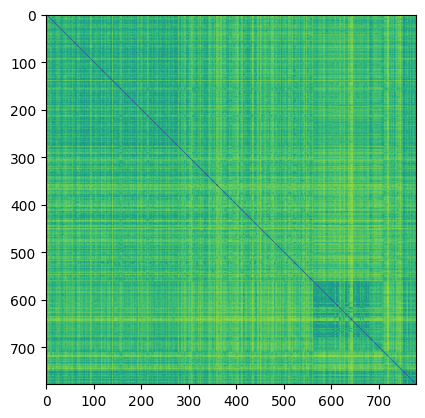

In [26]:
index = tm.index['llm_thoughts']
emb = index.reconstruct_batch(range(index.ntotal))
pd = pairwise_distances(emb, emb)
plt.imshow(pd)

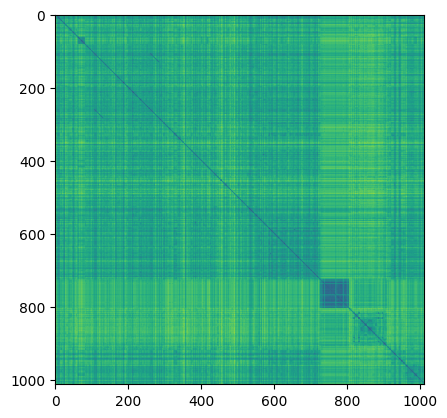

In [27]:
index = tm.index['paragraphs']
emb = index.reconstruct_batch(range(index.ntotal))
pd = pairwise_distances(emb, emb)
plt.imshow(pd)

In [11]:
tm.index['sentences'].compute_distance_subset

TypeError: IndexFlat.compute_distance_subset() missing 5 required positional arguments: 'n', 'x', 'k', 'distances', and 'labels'

In [20]:
tm.index['sentences'].codes

<faiss.swigfaiss_avx2.UInt8Vector; proxy of <Swig Object of type 'std::vector< uint8_t > *' at 0x7259e2ee87e0> >

In [ ]:
text = "where memory can be passed not only from last layer to next segment first layer"
field = 'sentences'
nearest = tm.get_nearest(text, by_field=field)
for n in nearest:
    print('-'*25)
    print(n['distance'], n['name'], n[field][n['nearest_field']:])

-------------------------
8.170107 agile memory ['we have , where memory can be passed not only from last layer to next !', 'segment first layer, but also between same layers of different segments.', 'However there is no clear understanding what connections between memories are better than other.', "let's allow the model to chose itself what connections to use.", 'Then look at attention maps and define which connections are stronger and leave only these ones.', 'Apply smth like l1 regularization to leave out less attended connections.', 'add penalty to loss for attending to too many previous layers.', 'like stated in , memory maybe should be processed in another way unlike sequence tokens.', 'Not only can we change the memory attention pattern, but also we can add separate heads that deal only with memory tokens.', 'Such heads can be initialized with sequence heads and be stored and trained separately.']
-------------------------
9.853502 RMT improvements ['1. memory in each layer rath

In [27]:
text = "Было бы круто сделать рекуррентный трансформер с памятью и запустить его в телеграм бота для записи мыслей"
field = 'sentences'
nearest = tm.get_nearest(text, by_field=field)
for n in nearest:
    print('-'*25)
    print(n['distance'], n['name'], n[field][n['nearest_field']])

-------------------------
6.8160906 Надо бы сделать трансформер и какой-то механизм Надо бы сделать трансформер и какой-то механизм памяти бы в него добавить, чтобы он мог обрабатывать длинные контексты.
-------------------------
7.965035 Надо подумать о том как рек... Надо подумать о том, как рекурентный трансформер с памятью может выглядеть в графовом виде.
-------------------------
8.063635 chat bot предлагает добавить тэг либо сделать обработку сообщения с помощью нейронки либо сохранить в бд заметок.
-------------------------
8.875177 прикольно было бы сохранять во внешнюю память прикольно было бы сохранять во внешнюю память искусственную, то что ранее не встречалась этим образам.
-------------------------
10.266054 прикольно было бы сохранять во внешнюю память Было бы увлекательно сохранять внешнюю память искусственную информацию, которая ранее не была представлена этими образами.


In [28]:
text = "Было бы круто сделать рекуррентный трансформер с памятью и запустить его в телеграм бота для записи мыслей"
field = 'paragraphs'
nearest = tm.get_nearest(text, by_field=field)
for n in nearest:
    print('-'*25)
    print(n['distance'], n['name'], n[field][n['nearest_field']])

-------------------------
6.8160906 Надо бы сделать трансформер и какой-то механизм Надо бы сделать трансформер и какой-то механизм памяти бы в него добавить, чтобы он мог обрабатывать длинные контексты.
-------------------------
8.368142 мысли Индия 10.22 нейро ведьмачий журнал: запись аудио, транскрипция, автотэггинг, детекция значимых событий, суммаризация,
- можно расширить память через внешние нейроны, добавить в ведьмака
- память может быть расширена, но в поле внимания предоставлены только самые релевантные воспоминания. механизм внимания ограничен, как и transformer attention 
- видос: подумать над философией: что надо рассказать, какие есть формы передачи информации, какие подходят
-------------------------
8.78056 ощутил на созвоне со сберде... ощутил на созвоне со сбердевайсами ограниченность своего кругозора внутри своей области. надо глубину обязательно дополнять шириной опыта. для этого проходиться по статьям и выделять банальные базовые вещи и записывать их систематическ

In [ ]:
text = "Было бы круто сделать рекуррентный трансформер с памятью и запустить его в телеграм бота для записи мыслей"
nearest = tm.get_nearest(text, by_field='llm_thoughts')
for n in nearest:
    print('-'*25)
    print(n['distance'], n['name'], n['llm_thoughts'][n['nearest_field']])

-------------------------
10.408655 Надо подумать о том как рек... A recurrent transformer with memory may be represented graphically, potentially revealing insights into its structure and multiple-segment processing
-------------------------
11.457323 RMT with EleutherAI They also touched on the limits of memorization and the potential to use transformers for reconstructing documents or images from shuffled inputs
-------------------------
11.88624 Attack on SCROLLS The goal is to compress long input data so that it can be processed by a transformer model without sacrificing task quality
-------------------------
12.705105 RMT related literature Add low-dimensional (16) memory states to the transformer encoder-decoder layer, which are attended and updated by separate attention modules
-------------------------
12.7340555 UNTITLED CHAT 2024-09-05 16 17 32 Этот туториал ACL 24 учит, как добавить экспрессивность в тексты с помощью различных техник и стилистических устройств


In [25]:
text = "Было бы круто сделать рекуррентный трансформер с памятью и запустить его в телеграм бота для записи мыслей"
nearest = tm.get_nearest(text, by_field='paragraphs')
for n in nearest:
    print('-'*25)
    print(n['distance'], n['name'], n['paragraphs'][n['nearest_field']])

-------------------------
6.8160906 Надо бы сделать трансформер и какой-то механизм Надо бы сделать трансформер и какой-то механизм памяти бы в него добавить, чтобы он мог обрабатывать длинные контексты.
-------------------------
8.368142 мысли Индия 10.22 нейро ведьмачий журнал: запись аудио, транскрипция, автотэггинг, детекция значимых событий, суммаризация,
- можно расширить память через внешние нейроны, добавить в ведьмака
- память может быть расширена, но в поле внимания предоставлены только самые релевантные воспоминания. механизм внимания ограничен, как и transformer attention 
- видос: подумать над философией: что надо рассказать, какие есть формы передачи информации, какие подходят
-------------------------
8.78056 ощутил на созвоне со сберде... ощутил на созвоне со сбердевайсами ограниченность своего кругозора внутри своей области. надо глубину обязательно дополнять шириной опыта. для этого проходиться по статьям и выделять банальные базовые вещи и записывать их систематическ

In [97]:
nearest[1]['paragraphs'][nearest[1]['nearest_field']]

'Actually many of retrieval methods use question or query in each segment. This requires processing segments separately and this might be the point where recurrence is stronger, along reasoning over long contexts.'

In [19]:
nearest = tm.get_nearest('Retrieval does not necessarily reflect what a model needs to complete the task. ', by_field='paragraphs')
for n in nearest:
    print(n['name'], n['paragraphs'][n['nearest_field']])

Unlimiformer seminar notes Retrieval does not necessarily reflect what a model needs to complete the task. 
!
По сути, задачи поиска похожие заметки или По сути, задачи поиска похожие заметки или нескольких похожих заметок в базе данных и дальнейшей генерация ответа или продолжение текущее заметки на основании подобранного очень похоже на модели retrieval. Каким-то образом нужно понять, как в эту парадигму устроить идею рекуррентный памяти, в чём же смысл рекуррентно сти в чём её преимущества перед retrieval и как их совместить.
DP retrieval seminar 020224 Symmetric vs Assymetric retrieval. First searches information  based on specific task and assymetric uses context without the task to select smth relevant
!
19-09-22 проблема в том, чтобы заставить модель искать важную информацию во всех сегментах и понимать их взаимосвязь. при прямом проходе с RMT это затруднительно, т.к. длинное течение градиентов.
Unlimiformer seminar notes Actually many of retrieval methods use question or query 

In [ ]:
def 

In [138]:
import ollama
def llm(query):
    response = ollama.chat(model='llama3',
                            messages=[{'role': 'user', 
                                        'content': query}])
    return response['message']['content']

In [114]:
text = '''08-09-22 11:08
#nlp #science 

---
## A Mathematical Framework for Transformer Circuits
[thread](https://transformer-circuits.pub/2021/framework/index.html#notation)
[YT playlist](https://www.youtube.com/playlist?list=PLoyGOS2WIonajhAVqKUgEMNmeq3nEeM51)

An attempt to interpret transformer as a combination of basic mathematical operations. In this paper only 0-2 layer **attention-only** (no MLP) transformers are studied, larger models are leaved for future work.

**Simplifications**
- MLP are hard to understand, so authors leave them out for elegance and simplicity.
- No biases
- No layer-norm
- decoder-only

### Summary of results

-   Zero layer transformers model bigram statistics. The bigram table can be accessed directly from the weights.
-   One layer attention-only transformers are an ensemble of bigram and “skip-trigram” The bigram and skip-trigram tables can be accessed directly from the weights.
-   Two layer attention-only transformers can implement much more complex algorithms using compositions of attention heads (also be detected directly from the weights).
-   One layer and two layer attention-only transformers use very different algorithms to perform in-context learning.

![[Pasted image 20220908112200.png]]

### Key takeaways
- Attention head is an individual operation outputting a result into a residual system.
- Attention is a sum of interpretable end-to-end functions
- QK and OV are largely independent
- q,k,v are intermediate results of multiplying low-rank Wq^TWk, WoWv
- Composition of heads greatly increases the expressivity
- token embedding, attention heads, MLP layers, and unembedding communicate with each other by reading and writing to different subspaces of the residual system **(?)**

# Paradigm

**Virtual weights**
Authors separate residual connection to a so-called **stream**, that serves as a communication highway for layers. It can be thought of as virtual weights that link any pair of layers. Information flows in this stream until specifically removed with an element. The bandwith of the stream is relatively low in comparison to the number of preceding neurons => hiddens are challenging to interpret, easier to find out what a single head does.

Each element (head) computes its own projection and adds it to the stream with own weight. Attention heads have low-dim projections (~64).

![[Pasted image 20220908112455.png]]

Some heads perform kind of **memory management** by writing out the negative version of some previously made changes.

![[Pasted image 20220908113642.png]]

It's important to think of attention heads as independent and additive elements that operate in parallel and add their output into the residual stream.

The fundamental action of attention heads is moving information. They gather information from stream tokens and rewrite it into another stream token. Read and Write tokens here are completely sepate from each other! So are operations performing them

### Observations
- Attention heads move informations between tokens
- Attention head is applying 2 linear operations: 
	- A=SM(qT\*k) - (non-linear one), governs information flow
	- WoWv - (linear one), which onformation is read and how to pass to destination
	- these operations act on different subspaces and act differently
- Wq & Wk, Wo & Wv always operate together => may be substituted by low-rank matrices Wov, Wqk
- q, k, v  are superficial, not really something crucial
- ![[Pasted image 20220912115534.png]]


## 0- and 1-layer Transformer
**0 - layer** just counts bi-gram statistics
**1 - layer**:

![[Pasted image 20220912115742.png]]

Rewrite using weight matrices and expand product: 
![[Pasted image 20220912130643.png]]
First term does not move informations, just updates bigram statistics
Second one links outputs and logits (kind of akin to [[gradient-based attention]] idea)

### Split second term into circuits
![[Pasted image 20220912133427.png]]

So we've got 2 independent patterns that have different purposes. It allows us e.g. to first compute all attentions, freeze them and then produce output values for all tokens. This way logits are a **linear function** of input tokens!

So we can just deal with matrices like *source*, *destination* -> *out*

**Problems**:
- large matrices for decent vocabs
- qk weights can have different scale across heads
- correlated variables

**Positives**
We can [explore](https://transformer-circuits.pub/2021/framework/head_dump/small_a.html) influence of bi-grams on output token probs by looking at maps.

**Occurring patterns**
- enormous fraction of attention capacity is copying ![[Pasted image 20220912134947.png]]
- In-context learning patterns ![[Pasted image 20220912135230.png]]
- Common phrases and constructions (e.g. `keep … [in → mind / at → bay / under → wraps]`, `difficult … not → impossible`)
- Python patterns:
	- Predicting that the python keywords `else`, `elif` and `except` are more likely after an indentation is reduced using skip-trigrams of the form: `\n\t\t\t … \n\t\t → else/elif/except` where the first part is indented N times, and the second part N-1, for various values of N, and where the whitespace can be tabs or spaces.
	- Predicting that `open()` will have a file mode string argument: `open … "," → [rb / wb / r / w]` (for example `open("abc.txt","r")`)
	- The first argument to a function is often `self`: `def … ( → self` (for example `def method_name(self):`)
- **(!)** most trigrams relate to tokenization specifics
- **(!)** many are hard to interpret without specific knowledge
- **(!)** OV and QK matrices (50k x 50k) have extremely low rank (64, 128)

### How common is copy behaviour?
Copy is generally mapping a word to itself in a different context
**Approach**: compare eigenvectors of OV matrices to the (1, 0) vector to find copying heads.

![[Pasted image 20220912140252.png]]

It appears that 10 of 12 heads are significantly copying! Well, on average. such eigenvalues are not rigorous proof.


## Two-layer Transformers
### Induction heads
### More circuits




---
[[00 NLP]]

---'''

In [135]:
def llm_get_thoughts(text):
    # prompt = '''Find 1-3 main ideas from the following text, formulate them very concisely. Text: {} Output !!ONLY!! 1-3 sentences: concise main ideas, separated by newline. '''
    prompt = '''Summarize the following text in 2-3 sentences, formulate it very concisely. Text: {} Output only the concise summary, 2-3 sentences.'''
    query = prompt.format(text)
    ans = llm(query)
    if '\n' in ans: 
        ans = ans.split('\n')[-1]
    thoughts = ans.split('.')
    thoughts = list(filter(len, thoughts))
    return thoughts

In [136]:
thoughts = llm_get_thoughts(text)

In [137]:
thoughts

['The paper presents a mathematical framework for understanding transformer circuits as combinations of basic mathematical operations',
 ' Specifically, it studies attention-only transformers with 0-2 layers and shows that these models can implement bigram statistics, skip-trigrams, and more complex algorithms using compositions of attention heads',
 ' The framework also reveals that attention heads move information between tokens and can be viewed as independent, additive elements operating in parallel']

In [103]:
ans = llm("Hello!")

In [104]:
ans

"Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?"

In [3]:
response = ollama.chat(model='llama3', messages=[
    {
        'role': 'user',
        'content': 'Hello!',
    },
    ])

In [ ]:
available_models = ['llama3', 'llava']

In [4]:
import base64

In [3]:
file_path = "/home/booydar/mpv-shot0001.jpg"
with open(file_path, 'rb') as f:
    img = f.read()
img_enc = base64.b64encode(img)

In [12]:
ollama.__version__

AttributeError: module 'ollama' has no attribute '__version__'

In [10]:
import ollama
response = ollama.chat(model='llava', messages=[
    {
        'role': 'user',
        'content': 'Whats on the image?',
        'images': [img_enc]
    },
    ])

In [11]:
response

{'model': 'llava',
 'created_at': '2024-04-25T16:50:32.524342442Z',
 'message': {'role': 'assistant',
  'content': ' The image shows a landscape with rocks and vegetation in the foreground. In the background, there appears to be a river or body of water running through a valley or canyon. The terrain is rugged with varying elevations, suggesting it might be part of a mountainous region.\n\nOn the right side of the image, there\'s an overlay of text and numerical data that seems to be related to a GPS or geographic tracking system. It includes information such as "F2.8 5041," which likely refers to the camera settings and GPS coordinates, along with "1/32s ISO: 640," which indicates exposure settings of the camera. The text also includes numbers like 2569, 5041, 4.73, 859, 1234, 0.83m, 200.00m/s, and 13.91, which might be additional data related to the GPS system or the image\'s metadata.\n\nThe specific details about what exactly is being measured or recorded with this equipment are no

In [5]:
response['message']

{'role': 'assistant',
 'content': "Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?"}

In [10]:
save_path = "/home/booydar/Desktop/_projects/tg_notebot/data/thoughts_cache"
note_db_path = "/home/booydar/Sync/obsidian-db"
model_name = "intfloat/multilingual-e5-large"
tm = ThoughtManager(note_db_path, 
                    model_name=model_name, 
                    save_path=save_path, 
                    device='cuda',
                    batch_size=64)

### Loading existing model ###


/home/booydar/Desktop/_projects/tg_notebot/env_neural/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/booydar/Desktop/_projects/tg_notebot/env_neural/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Parsing notes ###
### Finished parsing ###


In [11]:
thoughts = tm.note_db.thoughts.values

In [12]:
notes = tm.note_db.cleaned_note.unique()

In [ ]:
def summarize()

In [17]:
prompt = '''Summarize the context in one short sentence.\nContext: {}'''

def summarize(text, prompt=prompt):
    query = prompt.format(text)
    return llm(query)

In [18]:
notes[0]

'2022-11-30 01-48-47\n\n \nКлассно было в универе не париться о том, что поправишься, о том что будешь тупой с утра. Просто бухаешь а потом идёшь на пары.\n\n '

In [19]:
prompt = '''Summarize the context in one short sentence.\nContext: {}'''
summarize(notes[0], prompt)

"A student is expressing frustration that they didn't bother to review their notes the night before and are now having to go to class without being prepared."

In [21]:
note = notes[10]
note

'2022-12-23 13-17-12\n\n \nзабавно, что работу с обученными языковыми моделями можно сравнить с упрощением, потому что у самой модели нет никакой цели или глобального критерия правильности, кроме лоса, но вас не может нам помочь для решения задачи, на которую модель не была обучена.. это превращает inference или 0-shot модели в некоторое подобие укрощения или родео, где с помощью заправок и уговоров. Мы пытаемся заставить модели сделать то, что нам нужно.\n\n '

In [35]:
prompt = '''Context: {}\n Get 1-5 keywords for the context. Output ONLY keywords, split by a comma. Do NOT output anything else.'''
llm(prompt.format(note))

'language, models, simplification, inference, task'

In [36]:
keywords = [llm(prompt.format(note)) for note in notes[:30]]

In [37]:
for k, n in zip(keywords, notes):
    print(k, n)

university, morning, classes, studying, habits 2022-11-30 01-48-47

 
Классно было в универе не париться о том, что поправишься, о том что будешь тупой с утра. Просто бухаешь а потом идёшь на пары.

 
photography, timeline, classification, images, sorting 2022-12-24 11-16-56

 
Сайт с фотографиями, которые расположены в виде ленты. Сначала самая последняя потом по возрастанию возраста плюс, когда открываешь одну отдельную фотографию. Только ней подбираются наиболее похожи похожи стреляется базам случаев по среднему вектору, который получен с помощью обычного картона. Что-то типа разрезанная взять, а классификационная, чтобы получить распределение классов как бы.

 
death, life, fear, suffering, happiness 2023-06-16 18-28-26

 
Человек смерти боится, потому что жизнь любит вот как я понимаю. Итак, природа велела. Но это подло и тут весь обман жизнь есть боль жизни. Страх и человек несчастен. Теперь всё боль и страх. Теперь человек жизнь любит, потому что боль и страх любит и так сделали